# Prediksjon av nedbør

## Felles import for alle kodeblokker

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler

import ipywidgets as widgets
from IPython.display import display, clear_output

# Felles for å lage egen DF for Oslo
df_oslo = pd.read_csv("../../data/processed/vaerdata_oslo.csv")
df_oslo.columns = df_oslo.columns.str.strip()
df_oslo['elementId'] = df_oslo['elementId'].astype(str).str.strip()
df_oslo['referenceTime'] = pd.to_datetime(df_oslo['referenceTime'], errors='coerce')
df_oslo['value'] = pd.to_numeric(df_oslo['value'], errors='coerce')
df_oslo = df_oslo.dropna(subset=['value'])

## Årlig maksimumstemperatur

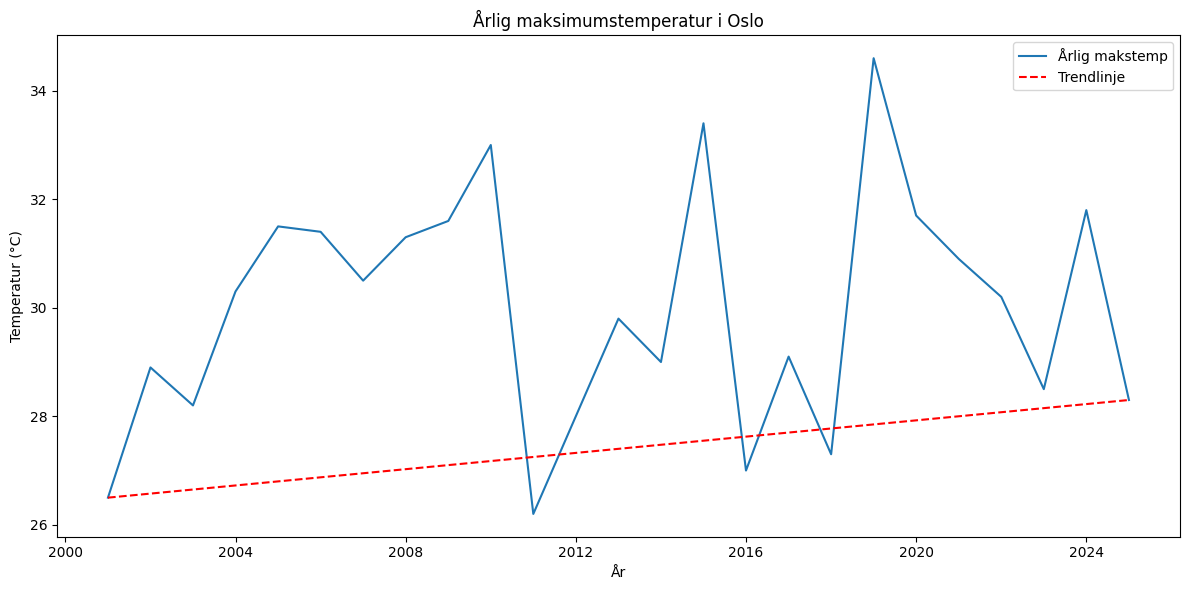

In [2]:
# --- 2. Filtrer for maks temperatur ---
max_temp_data = df_oslo[df_oslo['elementId'] == 'max(air_temperature P1D)'].copy()
max_temp_data['value'] = pd.to_numeric(max_temp_data['value'], errors='coerce')
max_temp_data = max_temp_data.dropna(subset=['value'])

# Sett dato som index for resampling
max_temp_data.set_index('referenceTime', inplace=True)

annual_max_temp = max_temp_data['value'].resample('YE').max()


plt.figure(figsize=(12, 6))
plt.plot(annual_max_temp, label='Årlig makstemp')
plt.plot([annual_max_temp.index[0], annual_max_temp.index[-1]],
         [annual_max_temp.iloc[0], annual_max_temp.iloc[-1]],
         color='red', linestyle='--', label='Trendlinje')
plt.title('Årlig maksimumstemperatur i Oslo')
plt.ylabel('Temperatur (°C)')
plt.xlabel('År')
plt.legend()
plt.tight_layout()
plt.show()


## Frekvens av maksimal

Måneden med oftest maks temperatur: 7


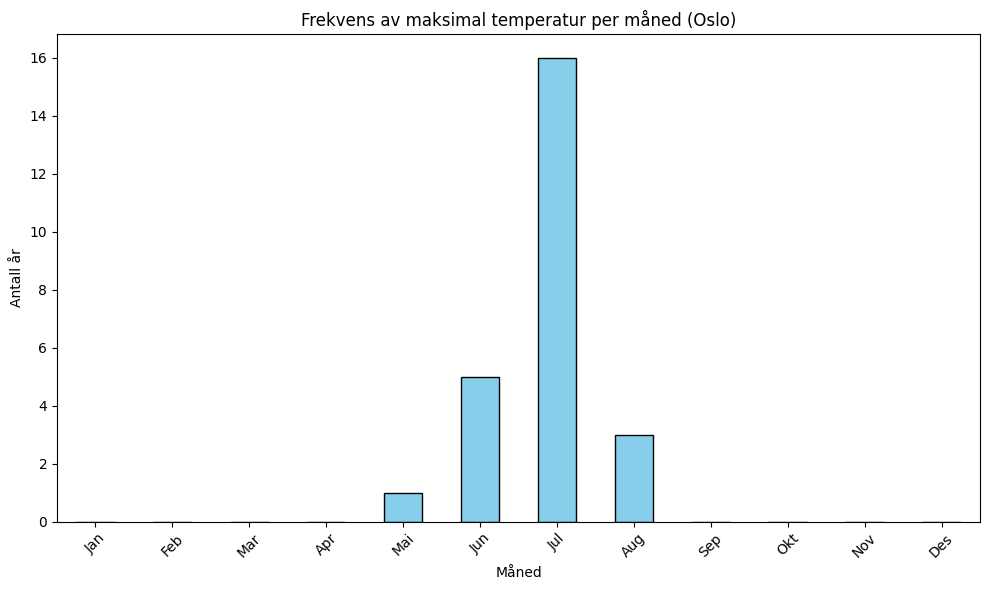

In [3]:
# --- 2. Filtrer kun maks temperatur ---
df_max = df_oslo[df_oslo['elementId'] == 'max(air_temperature P1D)'].copy()

# --- 3. Finn hvilken dato som hadde maks temperatur hvert år ---
df_max['year'] = df_max['referenceTime'].dt.year
max_temp_dates = df_max.loc[df_max.groupby('year')['value'].idxmax()]

# --- 4. Ekstraher måneden og tell frekvenser ---
max_temp_months = max_temp_dates['referenceTime'].dt.month
most_common_month = max_temp_months.value_counts().idxmax()
print("Måneden med oftest maks temperatur:", most_common_month)

# --- 5. Visualiser frekvens per måned ---
month_frequencies = max_temp_months.value_counts().sort_index()
all_months = pd.Series(0, index=np.arange(1, 13))
month_frequencies = all_months.add(month_frequencies, fill_value=0).sort_index()

plt.figure(figsize=(10, 6))
month_frequencies.plot(kind='bar', color='skyblue', edgecolor='black')

plt.xlabel('Måned')
plt.ylabel('Antall år')
plt.title('Frekvens av maksimal temperatur per måned (Oslo)')
plt.xticks(ticks=np.arange(12), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'Mai', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Des'
], rotation=45)
plt.tight_layout()
plt.show()


## Årlig minstetempratur

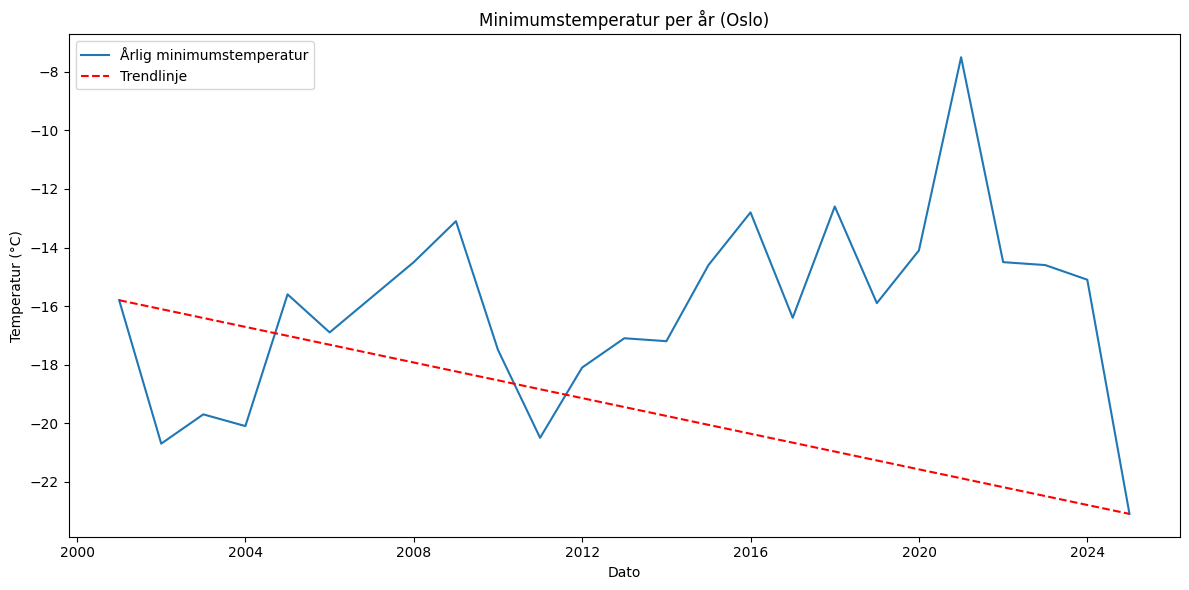

In [4]:
# --- 2. Filtrer til minimum temperatur ---
df_min = df_oslo[df_oslo['elementId'] == 'min(air_temperature P1D)'].copy()
df_min.set_index('referenceTime', inplace=True)

# --- 3. Finn årlig minimumstemperatur ---
min_temp = df_min['value'].resample('YE').min()


plt.figure(figsize=(12, 6))
plt.plot(min_temp, label='Årlig minimumstemperatur')
plt.plot([min_temp.index[0], min_temp.index[-1]], [min_temp.iloc[0], min_temp.iloc[-1]],
         color='red', linestyle='--', label='Trendlinje')

plt.title('Minimumstemperatur per år (Oslo)')
plt.xlabel('Dato')
plt.ylabel('Temperatur (°C)')
plt.legend()
plt.tight_layout()
plt.show()


Måneden hvor minimumstemperaturen oftest forekommer: 1


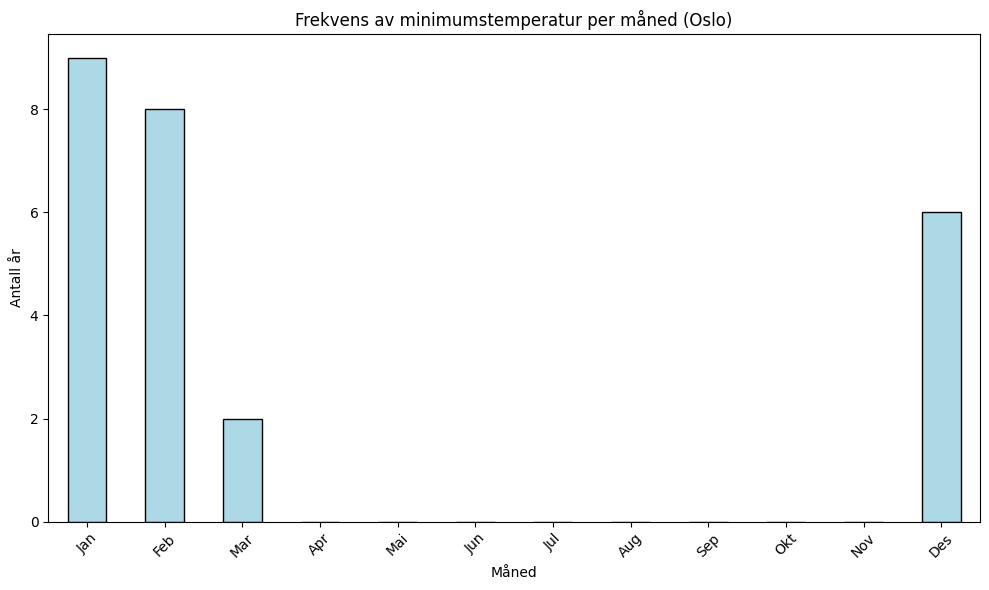

In [5]:
# --- 5. Finn datoer med minimum hvert år ---
df_min = df_oslo[df_oslo['elementId'] == 'min(air_temperature P1D)'].copy()
df_min['referenceTime'] = pd.to_datetime(df_min['referenceTime'], errors='coerce')
df_min = df_min.dropna(subset=['value'])

df_min['year'] = df_min['referenceTime'].dt.year
min_temp_dates = df_min.loc[df_min.groupby('year')['value'].idxmin()]
min_temp_months = min_temp_dates['referenceTime'].dt.month

# --- 6. Frekvenser per måned ---
most_common_month = min_temp_months.value_counts().idxmax()
print("Måneden hvor minimumstemperaturen oftest forekommer:", most_common_month)

month_frequencies = min_temp_months.value_counts().sort_index()
all_months = pd.Series(0, index=np.arange(1, 13))
month_frequencies = all_months.add(month_frequencies, fill_value=0).sort_index()

# --- 7. Visualiser ---
plt.figure(figsize=(10, 6))
month_frequencies.plot(kind='bar', color='lightblue', edgecolor='black')

plt.xlabel('Måned')
plt.ylabel('Antall år')
plt.title('Frekvens av minimumstemperatur per måned (Oslo)')
plt.xticks(ticks=np.arange(12), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'Mai', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Des'
], rotation=45)
plt.tight_layout()
plt.show()


## Logistisk regresjon og Naive Byes-modellen

I dette steget skal det implementeres to maskinlæringsmodeller for å forutsi været, nærmere bestemt hvorvidt det vil regne eller ikke, basert på maksimums- og minimumstemperaturen. Prediksjonenemodellene er to vanlige klassifikasjonsalgoritmer/modeller.

### Logistisk regresjon

In [6]:
# 1. Filtrer ut relevante målinger fra df_oslo
df_max = df_oslo[df_oslo['elementId'] == 'max(air_temperature P1D)'][['referenceTime', 'value']].rename(columns={'value': 'TMAX'})
df_min = df_oslo[df_oslo['elementId'] == 'min(air_temperature P1D)'][['referenceTime', 'value']].rename(columns={'value': 'TMIN'})

# 2. Slå sammen de to
df_combined = pd.merge(df_max, df_min, on='referenceTime', how='inner')

# 3. Legg til nedbør hvis du har det – her antar vi du har elementId = 'sum(precipitation_amount P1D)'
df_rain = df_oslo[df_oslo['elementId'] == 'sum(precipitation_amount P1D)'][['referenceTime', 'value']].rename(columns={'value': 'RAIN'})
df_combined = pd.merge(df_combined, df_rain, on='referenceTime', how='inner')

# 4. Lag en binær kolonne for regn: 1 hvis det regnet, ellers 0
df_combined['RAIN'] = (df_combined['RAIN'] > 0).astype(int)

# 5. Dropp evt. manglende verdier
df_combined = df_combined.dropna()

# 6. Feature og label
X = df_combined[['TMAX', 'TMIN']]
y = df_combined['RAIN']

# 7. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 8. Skalering
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 9. Modelltrening
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# 10. Prediksjon og evaluering
y_pred = model.predict(X_test_scaled)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[3459 1674]
 [1511 3554]]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.67      0.68      5133
           1       0.68      0.70      0.69      5065

    accuracy                           0.69     10198
   macro avg       0.69      0.69      0.69     10198
weighted avg       0.69      0.69      0.69     10198



#### Evaluering av logistisk regresjon
Denne modellen klarer å predikere 3459 true positive verdier og 3554 true negative verdier. Modellen er 69% nøyaktig.

### Naive Byes

In [7]:
model2 = GaussianNB()
model2.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model2.predict(X_test_scaled)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[2307 2826]
 [1326 3739]]

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.45      0.53      5133
           1       0.57      0.74      0.64      5065

    accuracy                           0.59     10198
   macro avg       0.60      0.59      0.58     10198
weighted avg       0.60      0.59      0.58     10198



#### Evaluering av Naive Byes

Denne modellen klarer å predikere 2307 true positive verdier og 3739 true negative verdier. Modellen er 59% nøyaktig.

Ettersom logistisk regresjon er mer nøyaktig enn Naive Byes, benyttes førstnevnte til å prediktere den nye dataen.

### Prediksjon av nåtid
Vi kan forutsi regn ved å predikere nedbørsmengden basert på maksimums- og minimumstemperaturen. Hvis nedbøren er positiv, vil det regne; ellers vil det ikke regne. For å forutsi nedbørsmengden kan en enkel lineær regresjon med to funksjoner (maksimums- og minimumstemperatur) gjøre jobben.

In [8]:
# 2. Filtrer for relevant timeOffset og relevante målinger
df_oslo = df_oslo[df_oslo['timeOffset'] == 'PT18H']
df_oslo = df_oslo[df_oslo['elementId'].isin([
    'max(air_temperature P1D)',
    'min(air_temperature P1D)',
    'sum(precipitation_amount P1D)'
])]

# 3. Gjør om referenceTime til dato og pivotér
df_oslo['date'] = pd.to_datetime(df_oslo['referenceTime']).dt.date
df_oslo_pivot = df_oslo.pivot_table(index='date', columns='elementId', values='value').dropna()

# 4. Gi enkle kolonnenavn
df_oslo_pivot.columns = ['TMAX', 'TMIN', 'PRCP']  # i riktig rekkefølge etter elementId

X = df_oslo_pivot[['TMAX', 'TMIN']]
y = df_oslo_pivot['PRCP']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

new_data = pd.DataFrame({'TMAX': [5], 'TMIN': [-2]})
new_prediction = model.predict(new_data)

print("\nPrediksjon for ny data:", new_prediction)

if new_prediction[0] > 0:
    print("Det kommer til å regne ")
else:
    print("Det blir ikke regn ")


Mean Squared Error: 23.9126597174319
R² Score: 0.11489291556720393

Prediksjon for ny data: [1.52755065]
Det kommer til å regne 


#### Mean Squared Error

Modellen fikk en Mean Squared Error (MSE) på 23.91. MSE måler den gjennomsnittlige kvadrerte forskjellen mellom de faktiske og predikerte verdiene. Dette tallet alene sier lite uten kontekst, men dersom nedbøren i datasettet typisk ligger i området 0–20 mm, er dette et relativt høyt avvik. Det antyder at modellen har utfordringer med å forutsi presise nedbørsmengder, noe som ikke er overraskende med så få forklaringsvariabler.

#### R²-score

Modellen har en R²-score på 0.11, noe som betyr at modellen forklarer kun 11 % av variasjonen i nedbøren. Dette er en lav verdi og tyder på at maksimum- og minimumstemperatur alene ikke er tilstrekkelige for å forklare eller predikere nedbørsmengder på en presis måte. Det er rimelig, da nedbør også påvirkes av faktorer som lufttrykk, vindretning, fuktighet og topografi.

For nye temperaturdata (TMAX = 5, TMIN = -2) predikerte modellen en nedbørsmengde på 1.53 mm. Ettersom denne verdien er over 0, konkluderer modellen med at det vil komme regn. Dette er i tråd med realistiske værforhold, da slike temperaturer ofte er forbundet med lett regn eller sludd, spesielt i byer som Oslo.

#### Konklusjon
Modellen fungerer OK til å gi et grovt estimat om det kommer til å regne eller ikke.



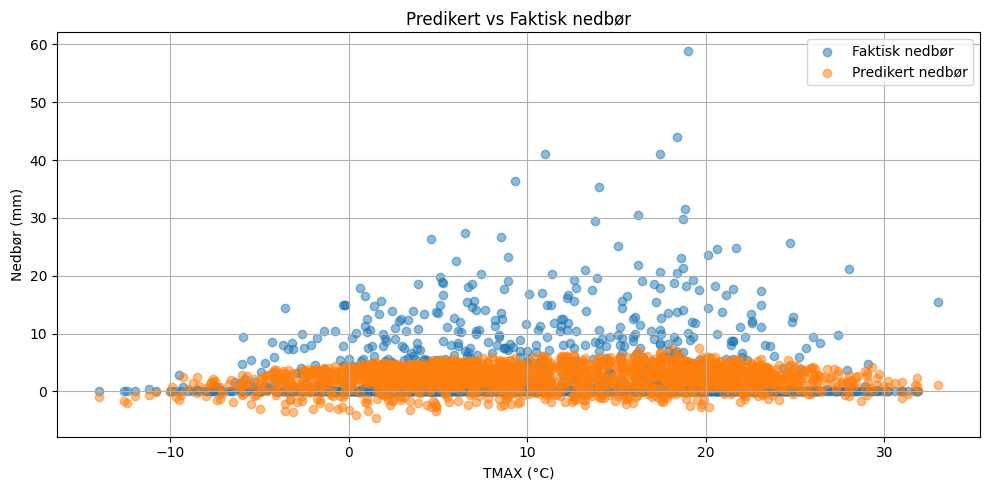

In [9]:
plt.figure(figsize=(10, 5))
plt.scatter(X_test['TMAX'], y_test, label='Faktisk nedbør', alpha=0.5)
plt.scatter(X_test['TMAX'], y_pred, label='Predikert nedbør', alpha=0.5)
plt.xlabel('TMAX (°C)')
plt.ylabel('Nedbør (mm)')
plt.title('Predikert vs Faktisk nedbør')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
tmax_slider = widgets.FloatSlider(value=5, min=-20, max=35, step=0.5, description='Legg inn maksimumstemperatur (°C)')
tmin_slider = widgets.FloatSlider(value=-2, min=-30, max=25, step=0.5, description='Legg inn minimumstemperatur (°C)')
button = widgets.Button(description='Prediker nedbør')

output = widgets.Output()

def on_button_click(b):
    with output:
        clear_output()
        new_input = pd.DataFrame({'TMAX': [tmax_slider.value], 'TMIN': [tmin_slider.value]})
        prediction = model.predict(new_input)[0]
        print(f"Predikert nedbør: {prediction:.2f} mm")
        if prediction > 0:
            print("Det vil sannsynligvis regne")
        else:
            print("Det vil sannsynligvis ikke regne")

button.on_click(on_button_click)

display(tmax_slider, tmin_slider, button, output)


FloatSlider(value=5.0, description='Legg inn maksimumstemperatur (°C)', max=35.0, min=-20.0, step=0.5)

FloatSlider(value=-2.0, description='Legg inn minimumstemperatur (°C)', max=25.0, min=-30.0, step=0.5)

Button(description='Prediker nedbør', style=ButtonStyle())

Output()